In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import gpflow as gpf

In [2]:
np.linspace(1,10, 10)[:, None]

array([[ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 8.],
       [ 9.],
       [10.]])

In [3]:
def f1(X, add_noise=False):
    target = X * np.sin(X) + np.sqrt(16*X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 1, size=target.shape)
    return target.squeeze()

f2 = np.cos
transform = np.exp

In [4]:
X = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)

# Compute loc and scale as functions of input X
loc = f1(X, add_noise=False).reshape(-1,1)
scale = transform(f2(X))

# Sample outputs Y from Gaussian Likelihood
Y = np.random.normal(loc, scale)

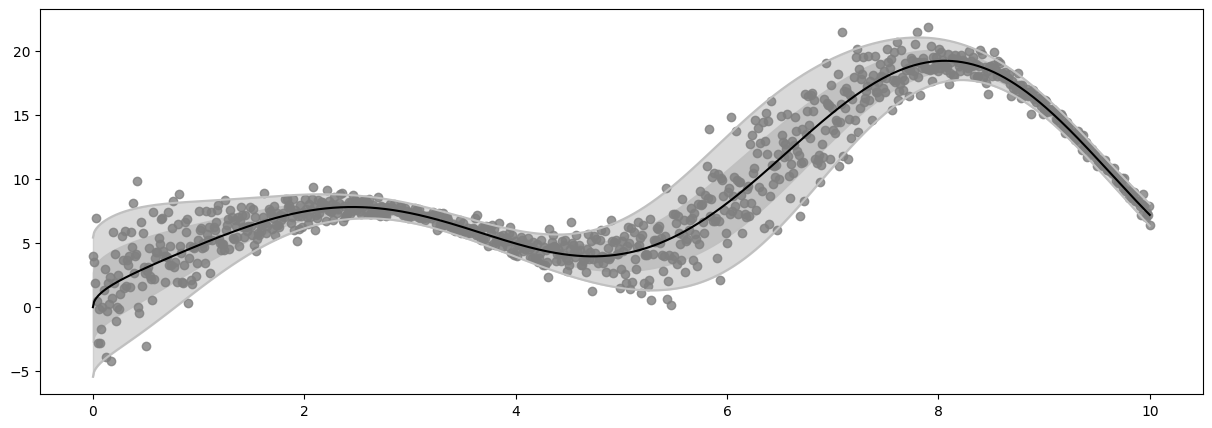

In [5]:
def plot_distribution(X, Y, loc, scale):
    plt.figure(figsize=(15, 5))
    x = X.squeeze()
    for k in (1, 2):
        lb = (loc - k * scale).squeeze()
        ub = (loc + k * scale).squeeze()
        plt.fill_between(x, lb, ub, color="silver", alpha=1 - 0.05 * k ** 3)
    plt.plot(x, lb, color="silver")
    plt.plot(x, ub, color="silver")
    plt.plot(X, loc, color="black")
    plt.scatter(X, Y, color="gray", alpha=0.8)
    plt.show()
    plt.close()


plot_distribution(X, Y, loc, scale)

In [6]:
likelihood = gpf.likelihoods.HeteroskedasticTFPConditional(
    distribution_class=tfp.distributions.Normal,  # Gaussian Likelihood
    scale_transform=tfp.bijectors.Exp(),  # Exponential Transform
)

print(f"Likelihood's expected latent_dim: {likelihood.latent_dim}")

Likelihood's expected latent_dim: 2


In [7]:
kernel = gpf.kernels.SeparateIndependent(
    [
        gpf.kernels.SquaredExponential(),  # This is k1, the kernel of f1
        gpf.kernels.SquaredExponential(),  # this is k2, the kernel of f2
    ]
)

In [8]:

M = 20  # Number of inducing variables for each f_i

# Initial inducing points position Z
Z = np.linspace(X.min(), X.max(), M)[:, None]  # Z must be of shape [M, 1]

inducing_variable = gpf.inducing_variables.SeparateIndependentInducingVariables(
    [
        gpf.inducing_variables.InducingPoints(Z),  # This is U1 = f1(Z1)
        gpf.inducing_variables.InducingPoints(Z),  # This is U2 = f2(Z2)
    ]
)

In [9]:
model = gpf.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=inducing_variable,
    num_latent_gps=likelihood.latent_dim,
)

model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,True,"(20, 1)",float64,[[0....
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,True,"(20, 1)",float64,[[0....
SVGP.q_mu,Parameter,Identity,,True,"(20, 2)",float64,"[[0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 20, 20)",float64,"[[[1., 0., 0...."


In [10]:
data = (X, Y)
loss_fn = model.training_loss_closure(data)

gpf.utilities.set_trainable(model.q_mu, False)
gpf.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpf.optimizers.NaturalGradient(gamma=0.1)

adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)


@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

Instructions for updating:
Use fn_output_signature instead


2024-06-12 12:03:41.761944: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 50 - Loss:  1835.0446


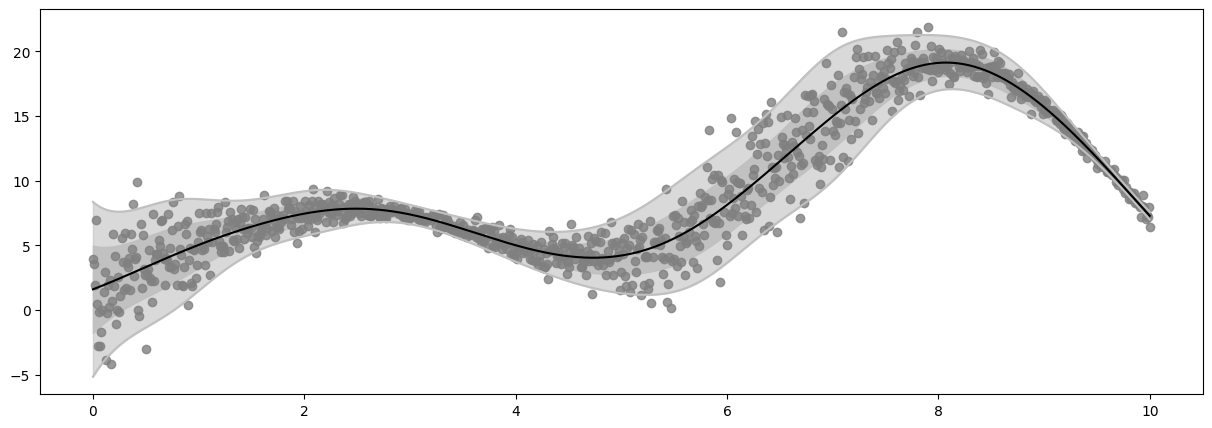

Epoch 100 - Loss:  1677.7298


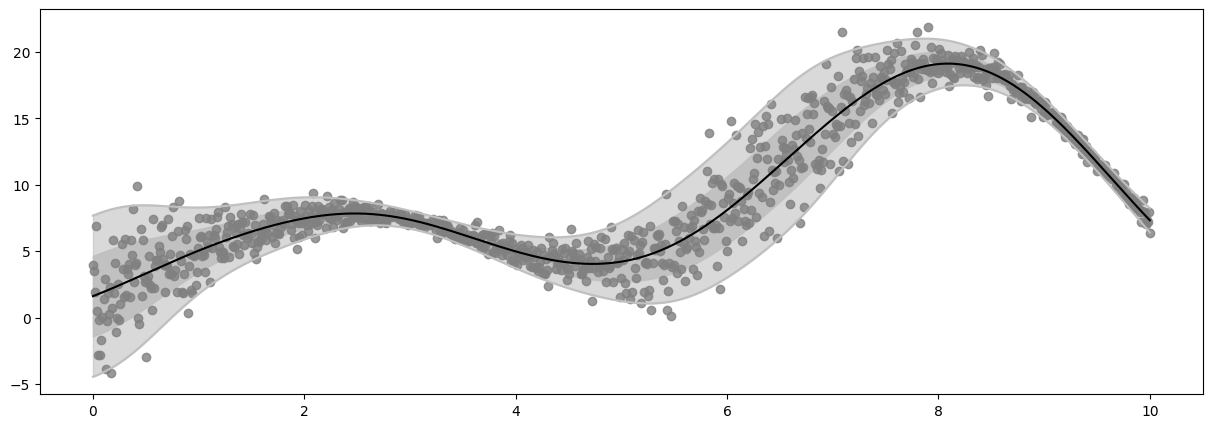

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.10027
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.02123
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.8635147496415141
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.9283925061939807
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,True,"(20, 1)",float64,[[-7.01829181e-04...
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,True,"(20, 1)",float64,[[0.12579881...
SVGP.q_mu,Parameter,Identity,,False,"(20, 2)",float64,"[[1.54196, 1.16594..."
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(2, 20, 20)",float64,"[[[3.85548169e-01, 0.00000000e+00, 0.00000000e+00..."


In [11]:
epochs = 100
log_freq = 50

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        Ymean, Yvar = model.predict_y(X)
        Ymean = Ymean.numpy().squeeze()
        Ystd = tf.sqrt(Yvar).numpy().squeeze()
        plot_distribution(X, Y, Ymean, Ystd)

model

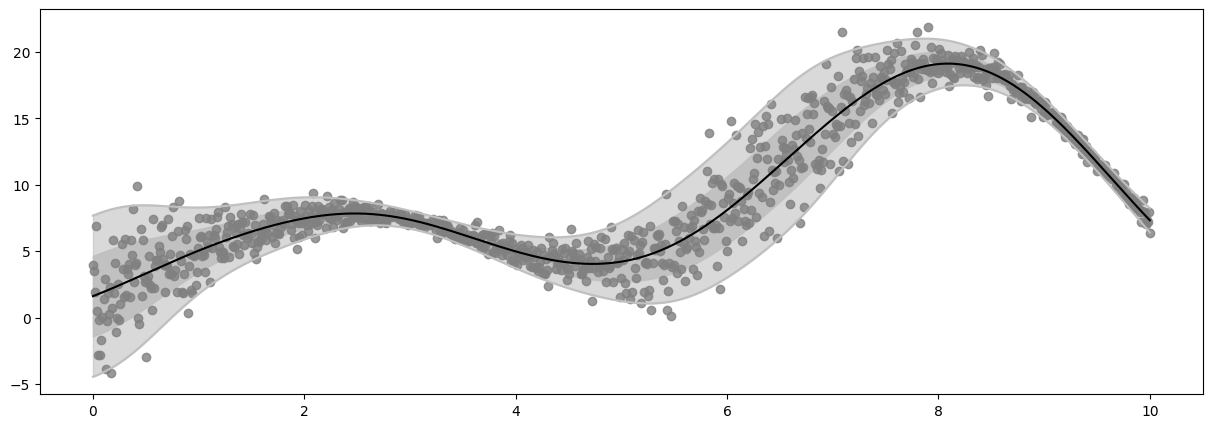

In [12]:
Ymean, Yvar = model.predict_y(X)
fmean, fvar = model.predict_f(X)
Ymean = Ymean.numpy().squeeze()
Ystd = tf.sqrt(Yvar).numpy().squeeze()
plot_distribution(X, Y, Ymean, Ystd)

In [13]:
fvar

<tf.Tensor: shape=(1000, 2), dtype=float64, numpy=
array([[0.16328674, 0.0224702 ],
       [0.15956432, 0.02139701],
       [0.15591514, 0.02037856],
       ...,
       [0.00760302, 0.01878805],
       [0.00811195, 0.01956044],
       [0.00865508, 0.02037465]])>

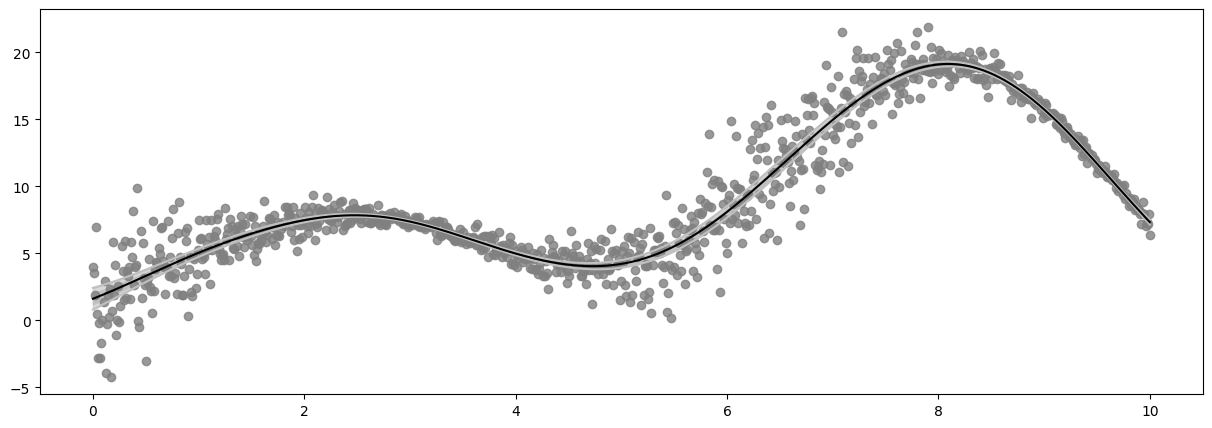

In [14]:
plot_distribution(X, Y, fmean[:,0].numpy().squeeze(), tf.sqrt(fvar[:,0]).numpy().squeeze())

## Fewer Data points

In [15]:
rng = np.random.RandomState(0)
X_train = rng.uniform(0, 10, size=15).reshape(-1, 1)
mean_train = f1(X_train, add_noise=False).reshape(-1,1)
scale_train = transform(f2(X_train))

np.random.seed(7) # random seed 17 is the same with mlhgp, but seems to be not working, change random seed to 7 seems working with n_rep = 5 LOL
y_train = np.random.normal(mean_train, scale_train)

In [16]:
# Set number of single observation repetition for "weight"
n_rep = 5
X_train_rep = np.repeat(X_train, repeats=n_rep, axis=0)
y_train_rep = np.repeat(y_train, repeats=n_rep, axis=0)

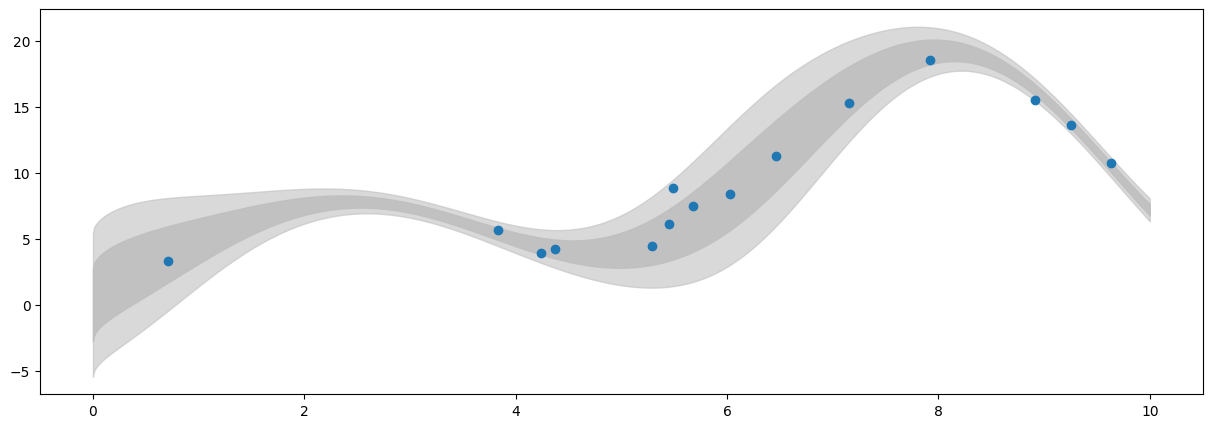

In [17]:
plt.figure(figsize=(15, 5))
x = X.squeeze()
for k in (1, 2):
    lb = (loc - k * scale).squeeze()
    ub = (loc + k * scale).squeeze()
    plt.fill_between(x, lb, ub, color="silver", alpha=1 - 0.05 * k ** 3)
plt.scatter(X_train, y_train)

In [18]:
kernel

name,class,transform,prior,trainable,shape,dtype,value
SeparateIndependent.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.10027
SeparateIndependent.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.02123
SeparateIndependent.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.863515
SeparateIndependent.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.928393


In [19]:
M = 10  # Number of inducing variables for each f_i

# Initial inducing points position Z
# Z = np.linspace(X_train.min(), X_train.max(), M)[:, None]  # Z must be of shape [M, 1]
Z = np.array([0.75, 3.7, 4.2, 5.5, 6, 6.5, 7, 8, 9, 9.5]).reshape(-1,1)

inducing_variable2 = gpf.inducing_variables.SeparateIndependentInducingVariables(
    [
        gpf.inducing_variables.InducingPoints(Z),  # This is U1 = f1(Z1)
        gpf.inducing_variables.InducingPoints(Z),  # This is U2 = f2(Z2)
    ]
)

In [20]:
likelihood2 = gpf.likelihoods.HeteroskedasticTFPConditional(
    distribution_class=tfp.distributions.Normal,  # Gaussian Likelihood
    scale_transform=tfp.bijectors.Exp(),  # Exponential Transform
)

In [21]:
kernel2 = gpf.kernels.SeparateIndependent(
    [
        gpf.kernels.SquaredExponential(),  # This is k1, the kernel of f1
        gpf.kernels.SquaredExponential(),  # this is k2, the kernel of f2
    ]
)

In [22]:
svargp = gpf.models.SVGP(
    # data=(X_train,y_train),
    kernel= kernel2,
    likelihood= likelihood2,
    inducing_variable=inducing_variable2,
    num_latent_gps=likelihood2.latent_dim
)

In [23]:
likelihood2

In [24]:
svargp

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,True,"(10, 1)",float64,[[0.75...
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,True,"(10, 1)",float64,[[0.75...
SVGP.q_mu,Parameter,Identity,,True,"(10, 2)",float64,"[[0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 10, 10)",float64,"[[[1., 0., 0...."


In [25]:
data = (X_train_rep, y_train_rep)
loss_fn = svargp.training_loss_closure(data)

gpf.utilities.set_trainable(svargp.q_mu, False)
gpf.utilities.set_trainable(svargp.q_sqrt, False)

variational_vars = [(svargp.q_mu, svargp.q_sqrt)]
natgrad_opt = gpf.optimizers.NaturalGradient(gamma=1.0)

adam_vars = svargp.trainable_variables
adam_opt = tf.optimizers.Adam(0.5)

opt = gpf.optimizers.Scipy()

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

In [26]:
epochs = 100
log_freq = 25

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
    #     Ymean, Yvar = vargp.predict_y(X)
    #     Ymean = Ymean.numpy().squeeze()
    #     Ystd = tf.sqrt(Yvar).numpy().squeeze()
    #     plot_distribution(X_train, y_train, Ymean, Ystd)

svargp

Epoch 25 - Loss:  143.2739
Epoch 50 - Loss:  127.9871
Epoch 75 - Loss:  124.9825
Epoch 100 - Loss:  123.3182


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,9.80044
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.70159
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.0010237584003700037
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.014564420894060716
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,True,"(10, 1)",float64,[[0.85616756...
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,True,"(10, 1)",float64,[[2.59868...
SVGP.q_mu,Parameter,Identity,,False,"(10, 2)",float64,"[[1.14885000e+000, 0.00000000e+000..."
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(2, 10, 10)",float64,"[[[1.56766926e-01, 0.00000000e+00, 0.00000000e+00..."


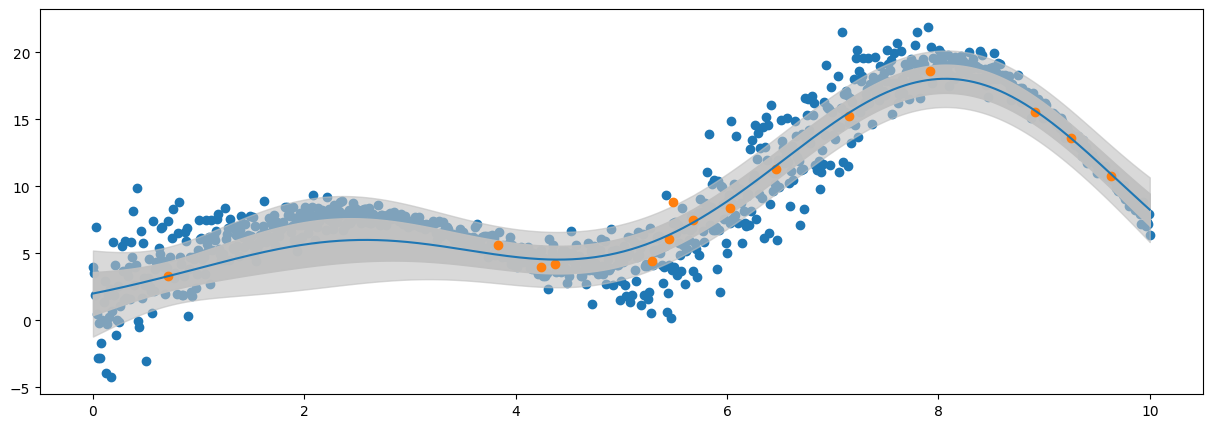

In [27]:
Ymean, Yvar = svargp.predict_y(X)
Ymean = Ymean.numpy().squeeze()
Ystd = tf.sqrt(Yvar).numpy().squeeze()

plt.figure(figsize=(15, 5))
plt.scatter(X,Y)
x = X.squeeze()
for k in (1, 2):
    lb = (Ymean - k * Ystd).squeeze()
    ub = (Ymean + k * Ystd).squeeze()
    plt.fill_between(x, lb, ub, color="silver", alpha=1 - 0.05 * k ** 3)
plt.plot(X, Ymean)
plt.scatter(X_train, y_train)